In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/Train')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [6]:
VEHICLES=10
ROADS=7

### Create dataloader

In [7]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape)
    return (y_img[:,:,2]==VEHICLES).astype(np.int64)
#     y_new[y_img[:,:,2]==ROADS] = 2
#     return y_new.astype(np.int64)

In [8]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return im
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [9]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0
    def get(self, tfm, x, y):
        x,y = super().get(tfm, x, y)
        y = (y[2,:,:]==VEHICLES).astype(np.float32)
        return x,y

In [10]:
def get_data(train_path, mask_path, bs):
    x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
    y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
    val_idxs = list(range(100))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
    denorm = md.trn_ds.denorm
    return md

In [11]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice_mult(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [12]:
f = resnet34
cut,lr_cut = model_meta[f]

In [13]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [14]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [15]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [16]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 1, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return torch.squeeze(x)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [17]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [18]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
#     learn.crit=nn.CrossEntropyLoss()
    learn.crit = nn.BCEWithLogitsLoss()
    learn.metrics=[accuracy_thresh(0.5), dice]
    return learn

In [19]:
TRAIN_DN = 'CameraRGB-128'
MASKS_DN = 'CameraSeg-128'
sz = 128
bs = 64

In [20]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [108]:
x,y = next(iter(md.trn_dl))

In [109]:
type(y)

torch.cuda.FloatTensor

In [110]:
learn = get_learner(md)

In [111]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.549133   2.3356582871045266e+23 0.166479   0.282681  



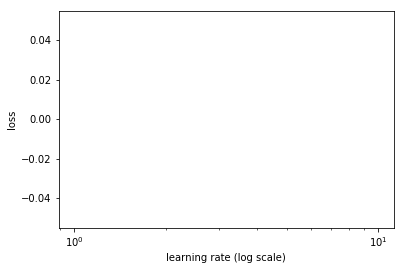

In [113]:
learn.lr_find()
learn.sched.plot()

In [115]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [116]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   <lambda>   dice           
    0      0.310965   10.967334  0.841868   0.075711  
    1      0.160651   0.195725   0.972507   0.919425       
    2      0.105356   0.029878   0.990905   0.972172       
    3      0.076808   0.021523   0.990145   0.976671        
    4      0.058816   0.026955   0.986905   0.964376        
    5      0.046589   0.015076   0.993483   0.982966        
    6      0.038267   0.015435   0.994482   0.982534        
    7      0.032341   0.011579   0.995366   0.987149        



[array([0.01158]), 0.9953656005859375, 0.9871491503723463]

In [117]:
learn.save('128urn-car-tmp')

In [118]:
learn.load('128urn-car-tmp')

In [119]:
learn.unfreeze()
learn.bn_freeze(True)

In [120]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.01635    0.010783   0.99572    0.98765   
    1      0.015983   0.010478   0.996028   0.988184        
    2      0.015236   0.009495   0.996258   0.989213        
    3      0.01451    0.00955    0.996128   0.989187        
    4      0.0141     0.009039   0.996389   0.989671        
    5      0.013663   0.009324   0.996174   0.989189        
    6      0.013296   0.008732   0.9967     0.989825        
    7      0.013016   0.00872    0.996578   0.98999         
    8      0.012625   0.008461   0.99673    0.99011         
    9      0.012317   0.008437   0.996678   0.990231        



[array([0.00844]), 0.9966784763336182, 0.9902309753253575]

In [121]:
learn.save('128urn-car-0')

In [122]:
learn.load('128urn-car-0')

In [127]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [128]:
# py = np.argmax(py,1)

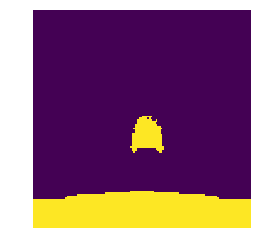

In [130]:
show_img(py[0]>0.5);

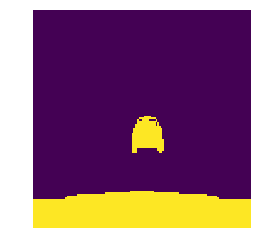

In [126]:
show_img(y[0]);

In [131]:
m.close()

NameError: name 'm' is not defined

## 256x256

In [132]:
TRAIN_DN = 'CameraRGB-256'
MASKS_DN = 'CameraSeg-256'
sz=256
bs=64

In [133]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [134]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [135]:
learn = get_learner(md)

In [136]:
learn.freeze_to(1)

In [137]:
learn.load('128urn-car-0')

In [138]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.067791   0.019673   0.992861   0.980269  
    1      0.044549   0.017447   0.992004   0.981173        
    2      0.033669   0.011987   0.995      0.987106        
    3      0.02718    0.009671   0.996316   0.989386        
    4      0.02305    0.008567   0.996605   0.990537        
    5      0.019873   0.008566   0.99646    0.9904          
    6      0.017675   0.008103   0.996956   0.991037        
    7      0.01591    0.00764    0.996993   0.991394        
    8      0.014583   0.007249   0.997013   0.991706        
    9      0.013653   0.00729    0.996969   0.991747        



[array([0.00729]), 0.9969689846038818, 0.9917465973251203]

In [142]:
learn.save('256urn-car-tmp')

In [143]:
learn.unfreeze()
learn.bn_freeze(True)

In [144]:
learn.load('256urn-car-tmp')

In [145]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.010752   0.006783   0.99723    0.992098  
    1      0.010597   0.007118   0.996934   0.991735        
    2      0.010345   0.006581   0.997348   0.99229         
    3      0.010022   0.00649    0.997355   0.992441        
    4      0.009826   0.006437   0.997393   0.992536         
    5      0.009556   0.006429   0.997335   0.992553         
    6      0.009346   0.006289   0.997414   0.992717         
    7      0.009245   0.006287   0.997454   0.992707         



[array([0.00629]), 0.9974539279937744, 0.9927072483807126]

In [146]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.008817   0.007458   0.996684   0.991313  
    1      0.008927   0.006326   0.997507   0.992658         
    2      0.00884    0.006159   0.997491   0.992804         
    3      0.00878    0.006034   0.997576   0.992951         
    4      0.008701   0.006228   0.997425   0.992777         
    5      0.008556   0.005946   0.997606   0.99306          
    6      0.008554   0.006009   0.99753    0.993009         
    7      0.008486   0.005965   0.997589   0.99305          



[array([0.00596]), 0.9975894236564636, 0.9930495458214642]

In [155]:
learn.save('256urn-car')

In [ ]:
learn.load('256urn-car')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
py = np.argmax(py,1)

In [ ]:
show_img(py[0]);

In [ ]:
show_img(y[0]);

In [ ]:
m.close()

## 512x512

In [20]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=512
bs=16

In [21]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

In [22]:
learn = get_learner(md)

In [23]:
learn.load('256urn-car')

In [24]:
learn.freeze_to(1)

In [25]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [162]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

  9%|▉         | 5/57 [00:08<01:28,  1.69s/it, loss=0.0304]
epoch      trn_loss   val_loss   <lambda>   dice            
    0      0.01951    0.009056   0.996964   0.989246  
    1      0.012453   0.009347   0.995591   0.988149        



[array([0.00935]), 0.9955906295776367, 0.9881492539425009]

In [163]:
learn.save('600urn-car-tmp')

In [164]:
learn.load('600urn-car-tmp')

In [165]:
learn.unfreeze()
learn.bn_freeze(True)

In [166]:
lrs = np.array([lr/200,lr/30,lr])

In [167]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.00857    0.00582    0.997552   0.993056  
    1      0.008348   0.005865   0.997518   0.993106         
    2      0.007846   0.005653   0.997724   0.993226         
    3      0.007428   0.005631   0.997681   0.993259         



[array([0.00563]), 0.9976810455322266, 0.9932590046201856]

In [168]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice             
    0      0.007487   0.005882   0.997604   0.993197  
    1      0.007286   0.005303   0.997718   0.993622         
    2      0.007094   0.00541    0.997721   0.993524         
    3      0.006946   0.005297   0.997787   0.993667         



[array([0.0053]), 0.9977866744995117, 0.9936667306994716]

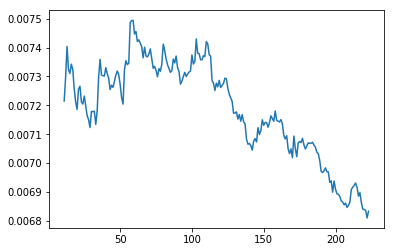

In [169]:
learn.sched.plot_loss()

In [170]:
learn.save('600urn-car')

In [26]:
learn.load('600urn-car')

In [27]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

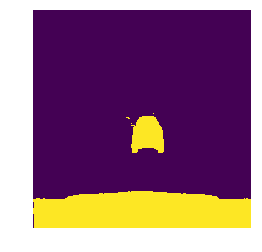

In [28]:
show_img(py[0]>0);

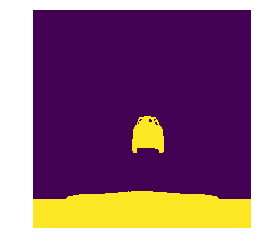

In [29]:
show_img(y[0]);

## Save results

In [20]:
import sys, skvideo.io, json, base64
import numpy as np
from PIL import Image
from io import BytesIO, StringIO

In [21]:
m_base = get_base()
m = to_gpu(Unet34(m_base))

In [22]:
# model_summary(m, [3,608,800])

In [23]:
# learn.load('1024urn')
load_model(m, str(PATH/'models/600urn-car.h5'))

In [24]:
# file = sys.argv[-1]
file = 'test_video.mp4'

if file == 'demo.py':
    print("Error loading video")
    quit

# Define encoder function
def encode(array):
    pil_img = Image.fromarray(array)
    buff = BytesIO()
    pil_img.save(buff, format="PNG")
    return base64.b64encode(buff.getvalue()).decode("utf-8")

video = skvideo.io.vread(file)

In [25]:
def normalize(x):
    m,s = imagenet_stats
    x = (x-m)/s
    return x
def preprocess(video):
    f1_norm = normalize(video)
    f1_roll = np.rollaxis(f1_norm, 3, 1)
    f1_pad = np.pad(f1_roll, [(0,0),(0,0),(0,8),(0,0)], mode='constant')
    return f1_pad

In [26]:
f1 = preprocess(video)

In [28]:
results = []
for i in range(0,f1.shape[0],8):
    xv = VV(torch.from_numpy(f1[i:i+8]).contiguous().float())
    preds = m(xv)
#     mx,idx = torch.max(preds, 1)
    preds = preds[:,:-8,:]
    i = F.softmax(preds)
    i = (i>0.5).long()
#     preds_bin = preds > 0.5
    results.append(i)

In [29]:
r_stacked = torch.cat(results,0)
r_np = r_stacked.data.cpu().numpy()

In [38]:
import matplotlib.pyplot as plt
def plot_res(index):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 15))
    f.tight_layout()
    ax1.imshow(video[index])
    ax2.imshow(r_np[index])

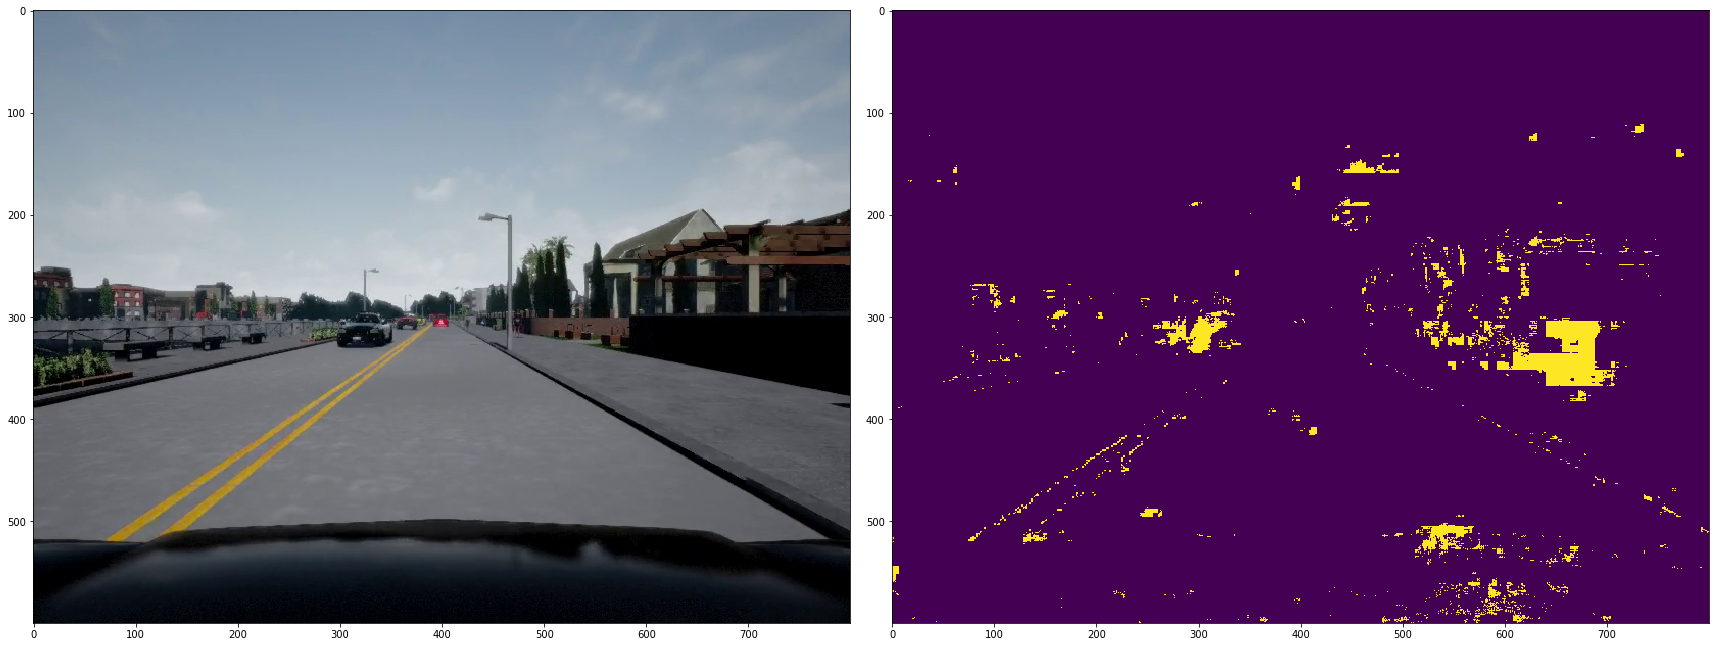

In [45]:
plot_res(30)

In [52]:
answer_key = {}

# Frame numbering starts at 1
frame_idx = 1
for frame in r_np:
    # Look for red cars :)
    binary_car_result = (frame==1).astype('uint8')
#     print(np.mean(binary_car_result))
    
    # Look for road :)
    binary_road_result = (frame==0).astype('uint8')

    answer_key[frame_idx] = [encode(binary_car_result), encode(binary_road_result)]
    
    # Increment frame
    frame_idx+=1

# Print output in proper json format
tester_data = json.dumps(answer_key)
with open('tester_data_car_only', 'w') as f:
    f.write(tester_data)
print(json.dumps(answer_key))

{"1": ["iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAAAAAC/Hd2sAAAj0klEQVR4nO2d57qkqhJAqf3N+79yzY82kAVFBF3r3rOng22kqAgYAwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABPIk+fAMCwiDF/T58DwLDo0ycAAADzgg8CkEAMPghAEjUICEASNAjAAQgIQAYEBCADAgKDIUNFVhEQGIsxxGOMswAAAAAAAADoDA4xAABcZjxlQh4ERmI4CRnuhODbiBlrpCsaBCADAgKD0NaYkUYlXQgIDEJzw6qJhPxrsROAVozkfxiDBgHIgoAAAHyPsQZeAQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAwLjI9qfb0QBmYW2wvWZgZOI4gAxoEGjCryFd79f39UFEJbG/nmuIMHk1NEFbL1/w+39EDvr26QgIjEygRKS5KOZBQKARGu3v2x+l7xIJ+CCT0jua05tWPs1ViGLNy/OtpzFi/KXTYjO09521HRNrUnqbGvcjRc5FX5NHFA0CkAEfBIYg5VM97WuhQaATIjOu+oQPAr3Q6aTDoEGgHzPKBwICfRCZM+qGgABkwAeBbpTYWKMpGjQIDIQOJRzGfFiD9BxTAMeo9+/+RWpUSB8+KyAIxyTI+s8zTwwT61XMl4gbHQTkVYxnw7fjGdn/rIk1ExX+Uo8xSyeob9yRa37EykKDzEBx